In [1]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  # Upgrade to Keras 3.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [2]:
import keras_nlp
import keras
import tensorflow as tf
import os

keras.utils.set_random_seed(42)

In [3]:
BATCH_SIZE = 64
EPOCHS = 3
MAX_SEQUENCE_LENGTH = 512
VOCAB_SIZE = 15000

EMBED_DIM = 128
INTERMEDIATE_DIM = 512

In [4]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2024-09-22 12:25:07--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.1MB/s    in 4.5s    

2024-09-22 12:25:12 (17.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [5]:
print(os.listdir("./aclImdb"))
print(os.listdir("./aclImdb/train"))
print(os.listdir("./aclImdb/test"))

['README', 'test', 'imdb.vocab', 'imdbEr.txt', 'train']
['urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat', 'neg', 'unsup', 'unsupBow.feat', 'urls_unsup.txt', 'pos']
['urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat', 'neg', 'pos']


In [6]:
!rm -rf aclImdb/train/unsup

In [7]:
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
)
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
)
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
train_ds = train_ds.map(lambda x, y: (tf.strings.lower(x), y))
val_ds = val_ds.map(lambda x, y: (tf.strings.lower(x), y))
test_ds = test_ds.map(lambda x, y: (tf.strings.lower(x), y))

In [10]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'an illegal immigrant resists the social support system causing dire consequences for many. well filmed and acted even though the story is a bit forced, yet the slow pacing really sets off the conclusion. the feeling of being lost in the big city is effectively conveyed. the little person lost in the big society is something to which we can all relate, but i cannot endorse going out of your way to see this movie.'
0
b"to get in touch with the beauty of this film pay close attention to the sound track, not only the music, but the way all sounds help to weave the imagery. how beautifully the opening scene leading to the expulsion of gino establishes the theme of moral ambiguity! note the way music introduces the characters as we are led inside giovanna's marriage. don't expect to find much here of the political life of italy in 1943. that's not what this is about. on the other hand, if you are susceptible to the music of images and sounds, you will be led into a word that reaches beyond

Tokenizing the data

We'll be using the keras_nlp.tokenizers.WordPieceTokenizer layer to tokenize the text. keras_nlp.tokenizers.WordPieceTokenizer takes a WordPiece vocabulary and has functions for tokenizing the text, and detokenizing sequences of tokens.

Before we define the tokenizer, we first need to train it on the dataset we have. The WordPiece tokenization algorithm is a subword tokenization algorithm; training it on a corpus gives us a vocabulary of subwords. A subword tokenizer is a compromise between word tokenizers (word tokenizers need very large vocabularies for good coverage of input words), and character tokenizers (characters don't really encode meaning like words do). Luckily, KerasNLP makes it very simple to train WordPiece on a corpus with the keras_nlp.tokenizers.compute_word_piece_vocabulary utility.

Note: The official implementation of FNet uses the SentencePiece Tokenizer.

In [11]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [12]:
reserved_tokens = ["[PAD]", "[UNK]"]
train_sentences = [element[0] for element in train_ds]
vocab = train_word_piece(train_ds, VOCAB_SIZE, reserved_tokens)

In [13]:
print("Tokens: ", vocab[100:110])


Tokens:  ['à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é']


In [14]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=False,
    sequence_length=MAX_SEQUENCE_LENGTH,
)

In [15]:
input_sentence_ex = train_ds.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'this picture seemed way to slanted, it\'s almost as bad as the drum beating of the right wing kooks who say everything is rosy in iraq. it paints a picture so unredeemable that i can\'t help but wonder about it\'s legitimacy and bias. also it seemed to meander from being about the murderous carnage of our troops to the lack of health care in the states for ptsd. to me the subject matter seemed confused, it only cared about portraying the military in a bad light, as a) an organzation that uses mind control to turn ordinary peace loving civilians into baby killers and b) an organization that once having used and spent the bodies of it\'s soldiers then discards them to the despotic bureacracy of the v.a. this is a legitimate argument, but felt off topic for me, almost like a movie in and of itself. i felt that "the war tapes" and "blood of my brother" were much more fair and let the viewer draw some conclusions of their own rather than be beaten over the head with t

In [16]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)


def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(512).prefetch(16).cache()


train_ds = make_dataset(train_ds)
val_ds = make_dataset(val_ds)
test_ds = make_dataset(test_ds)

In [29]:
train_ds

<CacheDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

FNET

In [18]:
input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [20]:
fnet_classifier.summary()
fnet_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
fnet_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "fnet_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │       1,985,536 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder (FNetEncoder)          │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_1 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_2 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,147,013 (27.26 MB)

 Trainable params: 2,382,337 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,764,676 (18.18 MB)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9816 - loss: 0.0504 - val_accuracy: 0.8624 - val_loss: 0.5482
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9737 - loss: 0.0708 - val_accuracy: 0.8632 - val_loss: 0.5500
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9902 - loss: 0.0269 - val_accuracy: 0.8586 - val_loss: 0.6134


In [21]:
fnet_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)


391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8461 - loss: 0.6304


[0.6511550545692444, 0.8434000015258789]

Transformer

In [22]:
NUM_HEADS = 2
input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")


x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer_classifier = keras.Model(input_ids, outputs, name="transformer_classifier")


transformer_classifier.summary()
transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
transformer_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │      1,985,536 │ input_ids[0][0]        │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │        198,272 │ token_and_position_em… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 128)      │        198,272 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, None, 128)      │        198,272 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ transformer_encoder_2… │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,580,481 (9.84 MB)

 Trainable params: 2,580,481 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.6546 - loss: 0.6510 - val_accuracy: 0.8856 - val_loss: 0.2750
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.9060 - loss: 0.2395 - val_accuracy: 0.8894 - val_loss: 0.2930
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.9442 - loss: 0.1567 - val_accuracy: 0.8674 - val_loss: 0.3980


In [23]:
transformer_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.8350 - loss: 0.5113


[0.5173237919807434, 0.8327999711036682]

Let's make a table and compare the two models. We can see that FNet significantly speeds up our run time (1.7x), with only a small sacrifice in overall accuracy (drop of 0.75%).

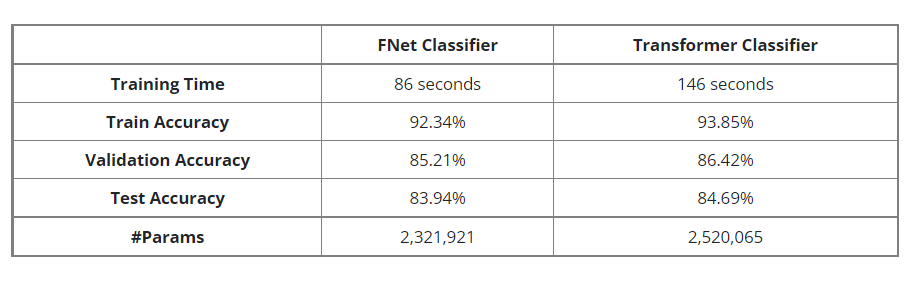